In [24]:
#Geo libraries
import rasterio
import geopandas as gpd
from osgeo import gdal
from osgeo import osr
from osgeo import ogr 
import shapefile
import rasterstats as rs

#Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Python base libraries
import re
import glob
import multiprocessing as mp

import numba
from numba import jit

import swifter
from numba import cuda

import dask.dataframe as dd
from dask.multiprocessing import get

In [60]:
%%time
pointsfile="AUS_points_5km.shp"
sjer_plots_points = gpd.read_file(pointsfile)
#sjer_plots_points=sjer_plots_points.iloc[::10, :]
# Create a buffered polygon layer from your plot location points
#sjer_plots_poly = sjer_plots_points.copy()
# Buffer each point using a 700 meter circle radius
# and replace the point geometry with the new buffered geometry
#sjer_plots_poly["geometry"] = sjer_plots_points.geometry.buffer(700)
#sjer_plots_poly.head()

Wall time: 11.6 s


In [10]:
#sjer_plots_points=sjer_plots_points.iloc[::100, :]

<AxesSubplot:>

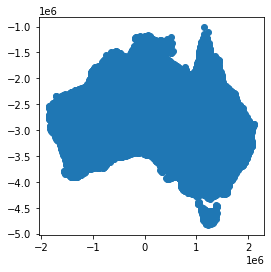

In [35]:
sjer_plots_points.plot()

In [4]:
folder="ABS1x1km_Aus_Pop_Grid_2006_2020/data_provided/"
tiffile="apg06e_f_001_20210512.tif"

In [5]:
# %%time
# ##RASTERIO
# src = rasterio.open(folder+tiffile)
# array_rasterio = src.read(1)
# nodataval= src.nodatavals

# if np.any(array_rasterio == nodataval):
#     array_rasterio[array_rasterio == nodataval] = np.nan
    
# print(np.shape(array_rasterio))

In [6]:
# plt.imshow(array_rasterio,vmin=0,vmax=1)
# plt.show()

In [7]:
%%time
##GDAL
gdal_data = gdal.Open(folder+tiffile)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()
array_gdal = gdal_data.ReadAsArray().astype(np.float)
gt = gdal_data.GetGeoTransform()

if np.any(array_gdal == nodataval):
    array_gdal[array_gdal == nodataval] = np.nan
    
print(np.shape(array_gdal))

(4100, 7401)
Wall time: 1.11 s


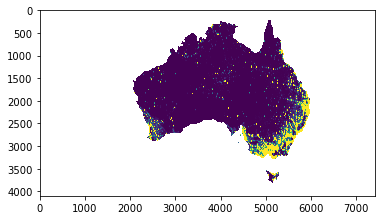

In [8]:
plt.imshow(array_gdal,vmin=0,vmax=1)
plt.show()

In [12]:
# %%time
# def returnValuePoints(x, y):
#     point = (x, y)
#     col = int((point[0] - -3901000.0) /1000.0)
#     row = int((point[1] - -1000000.0) / -1000.0)
#     return (row, col)

# sjer_plots_points["ind"] = sjer_plots_points.apply(lambda x: returnValuePoints(x.geometry.x, x.geometry.y), axis=1)

In [32]:
def coregPoint(point,data,region):
    '''
    Finds the nearest neighbour to a point from a bunch of other points
    point - array([longitude,latitude])
    data - array
    region - integer, same units as data
    '''
    tree = scipy.spatial.cKDTree(data)
    dists, indexes = tree.query(point,k=1,distance_upper_bound=region) 

    if indexes==len(data):
        return 'inf'
    else:
        return (indexes,dists)
    

@jit(nopython=True)
def points_in_circle(circle, arr):
    '''
    A generator to return all points whose indices are within given circle.
    Inspired from http://stackoverflow.com/a/2774284
    Global raster warning: If a point is near the the edges of the raster it will not loop 
    around to the other side of the raster!
    '''
    i0,j0,r = circle
    
    def intceil(x):
        return int(np.ceil(x))
    
    for i in range(intceil(i0-r),intceil(i0+r)):
        ri = np.sqrt(r**2-(i-i0)**2)
        for j in range(intceil(j0-ri),intceil(j0+ri)):
            if (i >= 0 and i < len(arr[:,0])) and (j>=0 and j < len(arr[0,:])):               
                yield arr[i][j]

# 
def coregRaster(j0,i0,data,region):
    '''
    Finds the mean value of a raster, around a point with a specified radius.
    point - array([longitude,latitude])
    data - array
    region - integer in index units
    '''
    pts_iterator = points_in_circle((i0,j0,region), data)
    pts = np.array(list(pts_iterator))   
    squares= np.count_nonzero(~np.isnan(pts))

    #return(scipy.stats.nanmean(pts)) #deprecated from scipy 0.15
    return(np.nansum(pts),squares)

@jit(nopython=True)
def coregRasterSquare(j0,i0,data,region):
    '''
    Finds the mean value of a raster, around a point with a specified radius.
    point - array([longitude,latitude])
    data - array
    region - integer in index units
    '''
    minx=j0-region
    maxx=j0+region
    miny=i0-region
    maxy=i0+region
    
    arrshp = np.shape(data)
    
    if minx < 0:
        minx = 0
    if maxx > arrshp[0]:
        maxx = arrshp[0]
    if miny < 0:
        miny = 0
    if maxy > arrshp[1]:
        maxy = arrshp[1]
        
    pts=data[minx:maxx,miny:maxy] 
    squares= np.count_nonzero(~np.isnan(pts))

    return(np.nansum(pts),squares)

  

#############
@cuda.jit
def coregRasterCUDA(j0,i0,r):
    '''
    Finds the mean value of a raster, around a point with a specified radius.
    point - array([longitude,latitude])
    data - array
    r - integer in index units
    '''
    
    def intceil(x):
        return int(np.ceil(x))
    
    def points_in_circle(i0,j0,r):
        for i in range(intceil(i0-r),intceil(i0+r)):
            ri = np.sqrt(r**2-(i-i0)**2)
            for j in range(intceil(j0-ri),intceil(j0+ri)):
                if (i >= 0 and i < len(cudarr[:,0])) and (j>=0 and j < len(cudarr[0,:])):               
                    return cudarr[i][j]
                
    pts_iterator = points_in_circle(i0,j0,r)
    
    pts = np.array(list(pts_iterator)) 
    
    squares= np.count_nonzero(~np.isnan(pts))

    #return(scipy.stats.nanmean(pts)) #deprecated from scipy 0.15
    return(np.nansum(pts),squares)




@jit(nopython=True)
def get_coords_at_point(gt, lon, lat):
    row = int((lon - gt[0])/gt[1])
    col = int((lat - gt[3])/gt[5])
    return (col, row)

In [75]:
cudarr = cuda.to_device(sjer_plots_points)

In [20]:
%%time

#threadsperblock = 32
#blockspergrid = (sjer_plots_points.size + (threadsperblock - 1)) // threadsperblock

#pop_area = sjer_plots_points.apply(lambda x: coregRasterCUDA[blockspergrid, threadsperblock](x.ind[0], x.ind[1],7), axis=1)

Wall time: 0 ns


In [61]:
%%time
sjer_plots_points["ind"] = sjer_plots_points.apply(lambda x: get_coords_at_point(gt, x.geometry.x, x.geometry.y), axis=1)

Wall time: 50.4 s


In [ ]:
# %%time
# for row in sjer_plots_points.itertuples():
# sjer_plots_points["ind"] = sjer_plots_points.apply(lambda x: get_coords_at_point(gt, x.geometry.x, x.geometry.y), axis=1)

In [37]:
%%time
pop_area = sjer_plots_points.apply(lambda x: coregRaster(x.ind[0], x.ind[1],array_gdal,7), axis=1)

Wall time: 6.08 s


In [38]:
%%time
pop_area = sjer_plots_points.apply(lambda x: coregRasterSquare(x.ind[0], x.ind[1],array_gdal,7), axis=1)

Wall time: 4.12 s


In [53]:
sjer_plots_points.ind[10][0]

102

In [64]:
np.shape(sjer_plots_points)

(307504, 3)

In [62]:
%%time
for row in sjer_plots_points.itertuples():
    pop_area = coregRasterSquare(row.ind[0], row.ind[1],array_gdal,7)

Wall time: 1.47 s


In [63]:
%%time
for row in sjer_plots_points.itertuples():
    pop_area = coregRaster(row.ind[0], row.ind[1],array_gdal,7)

Wall time: 11.5 s


In [49]:
%%time
pop_area = sjer_plots_points.swifter.set_npartitions(16).apply(lambda x: coregRaster(x.ind[0], x.ind[1],array_gdal,7), axis=1)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Wall time: 1min 44s


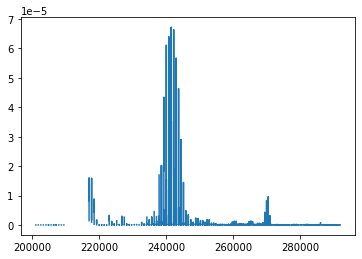

In [12]:
sjer_plots_points[['pop', 'area']] = pd.DataFrame(pop_area.tolist(), index=pop_area.index)
sjer_plots_points["pop_density"]=sjer_plots_points["pop"]/(sjer_plots_points["area"]*5000**2)
plt.plot(sjer_plots_points["pop_density"])

In [13]:
len(sjer_plots_points)

307504

In [41]:
cpus = mp.cpu_count()
print(cpus)
#pool = mp.Pool(processes=cpus)

8


In [13]:
def neighbour_distance(gdf_chunk):
    gdf_chunk.apply(lambda x: coregRaster(x.ind[0], x.ind[1],array_gdal,7), axis=1)

In [43]:
#intersection_chunks = np.array_split(sjer_plots_points, cpus)
#intersection_chunks = np.array_split(sjer_plots_points.ind, cpus)
ddata = dd.from_pandas(sjer_plots_points, npartitions=cpus)

In [44]:
res = ddata.map_partitions(lambda x: x.apply(lambda x: coregRaster(x.ind[0], x.ind[1],array_gdal,7), axis=1)).compute(get=get)  

ValueError: Metadata inference failed in `lambda`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
TypeError('data type not understood')

Traceback:
---------
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\utils.py", line 176, in raise_on_meta_error
    yield
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\core.py", line 5580, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\core.py", line 5560, in _extract_meta
    return tuple([_extract_meta(_x, nonempty) for _x in x])
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\core.py", line 5560, in <listcomp>
    return tuple([_extract_meta(_x, nonempty) for _x in x])
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\core.py", line 5556, in _extract_meta
    return x._meta_nonempty if nonempty else x._meta
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\core.py", line 379, in _meta_nonempty
    return meta_nonempty(self._meta)
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\utils.py", line 512, in __call__
    return meth(arg, *args, **kwargs)
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\backends.py", line 172, in meta_nonempty_dataframe
    dt_s_dict[dt] = _nonempty_series(x.iloc[:, i], idx=idx)
  File "c:\users\nbutter\miniconda3\envs\geopy\lib\site-packages\dask\dataframe\backends.py", line 287, in _nonempty_series
    data = np.array([entry, entry], dtype=dtype)


In [17]:
intersection_chunks = np.array_split(sjer_plots_points.ind, cpus)

In [18]:
np.shape(intersection_chunks[0])

(38438,)

In [22]:
type(intersection_chunks[0])

pandas.core.series.Series

In [40]:
pool = mp.Pool(processes=cpus)
chunk_processes=[pool.apply_async(neighbour_distance, args=(intersection_chunks)) for chunk in intersection_chunks]

In [ ]:
intersection_results = [chunk.get() for chunk in chunk_processes]

In [ ]:

    
    
    chunk_processes = [pool.apply_async(neighbour_distance, args=(intersection_chunks)) for chunk in intersection_chunks]
    
    intersection_results = [chunk.get() for chunk in chunk_processes]
    
#intersections_dist = gpd.GeoDataFrame(pd.concat(intersection_results), crs=sjer_plots_points.crs)
#return intersection_results

In [ ]:
%%time
intersection_results = parallelize()

In [60]:
x=sjer_plots_points.geometry.x[500]
y=sjer_plots_points.geometry.y[500]


In [83]:
proj = osr.SpatialReference(wkt=gdal_data.GetProjection())

In [79]:
gt

(-3901000.0, 1000.0, 0.0, -1000000.0, 0.0, -1000.0)

In [74]:
%%time
#val = df.apply(lambda x: coregRaster(sjer_plots_points.geometry.x, sjer_plots_points.geometry.y,700,array), axis=1)

radius = 7

col,row = get_coords_at_point(gt, x,y)
buff_arr = coregRaster(row, col,array_gdal,radius)

Wall time: 0 ns


In [90]:
print(np.count_nonzero(~np.isnan(array_gdal)))

print(area)

7690678
50.0


TypeError: Invalid shape (787131,) for image data

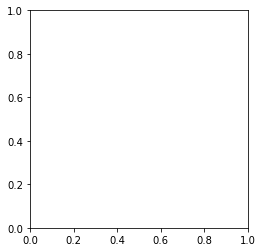

In [50]:
plt.imshow(buffer_points)

In [86]:
prj = gdal_data.GetProjection()
print(prj)

PROJCS["GDA_1994_Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [99]:
coords=shapes[0].points[0]

def get_coords_at_point(rasterfile, pos):
    gdata = gdal.Open(rasterfile)
    gt = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(np.float)
    row = int((pos[1] - gt[0])/gt[1])
    col = int((pos[0] - gt[3])/gt[5])
    return col, row

radius = 700 # in units of pixels

row, col = get_coords_at_point(tiffile, pos = coords) 
circle = (row, col, radius)

In [100]:
circle

(-2151, 2888, 700)

In [101]:
def points_in_circle(circle, arr):
    buffer_points = []
    i0, j0, r = circle
    
    def int_ceiling(x):
        return int(np.ceil(x))
    
    for i in range(int_ceiling(i0 - r), int_ceiling(i0 + r)):
        ri = np.sqrt(r**2 - (i - i0)**2)
        
        for j in range(int_ceiling(j0 - ri), int_ceiling(j0 + ri)):
            buffer_points.append(arr[i][j])
            arr[i][j] = np.nan
    
    return buffer_points

buffer_points = points_in_circle(circle, data_array)

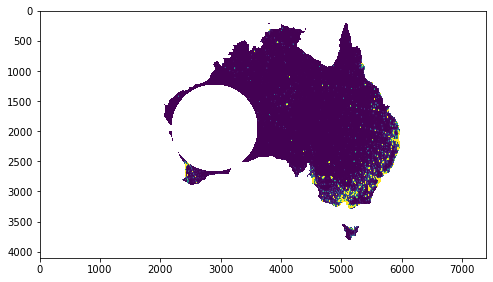

In [113]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
#plt.axis("off")
plt.imshow(data_array, cmap = "viridis",vmin=0,vmax=10)
#plt.plot(coords[0],coords[1],'kx')
plt.show()

In [114]:
mean = np.nanmean(buffer_points)
std = np.nanstd(buffer_points)
variance = np.nanvar(buffer_points)
summ = np.nansum(buffer_points)

In [117]:
variance

32.05252805112663

In [25]:
%%time


## Read in population rasters
poprasts = glob.glob('ABS1x1km_Aus_Pop_Grid_2006_2020/' +
                     'data_provided/apg07e_f_001_20210512.tif')

grid = gpd.read_file('AUS_points_5km.shp')

## Add an FID in there - if one doesn't already exist
grid.insert(0, 'FID', range(1, len(grid) + 1))


## To see how long it takes

Wall time: 27.8 s


In [26]:
## Define a 'sumna' function that removes missing, and any negative values
def sumna(x):
    return np.nansum(x[x>0])

## Function for one year's extract
def popbuff(buff):
    b = grid.geometry.buffer(buff)
    pop = rs.zonal_stats(b,
                         poprast.read(1),
                         nodata = 0,
                         affine = poprast.transform,
                         stats = 'sum',
                         add_stats = {'sumna' : sumna})
    out = gpd.GeoDataFrame(pop)['sumna']
    out = out/(b.area/1e6)
    return out

buffs = [700] #, 1000, 1500, 2000, 3000, 5000, 10000]

In [32]:
with rasterio.open(poprasts[0]) as poprast:
        yr = str(20) + re.sub(".*(apg|APG)(\\d{2}).*", "\\2", poprasts[0])
        print(yr)
        popdf = list(map(popbuff, buffs))

2007


KeyboardInterrupt: 

In [36]:
with rasterio.open(poprasts[0]) as poprast:
    print(poprast)
    print(poprast.read(1))

<open DatasetReader name='ABS1x1km_Aus_Pop_Grid_2006_2020/data_provided/apg07e_f_001_20210512.tif' mode='r'>
[[-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 ...
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]]


In [56]:

print(cuda.gpus)

<Managed Device 0>


In [55]:
import xrspatial

In [ ]:
from xrspatial import zonal_stats
zones_agg.values = np.nan_to_num(zones_agg.values, copy=False).astype(int)
zonal_stats(zones_agg, terrain)